
## ***Overview***

1. Data Loading and Preprocessing:

Raw Data Visualization: The code starts by loading images from a directory, converting them to grayscale, flattening the image data, and storing it in a Pandas DataFrame. It then performs basic visualizations like class distribution and pixel intensity histograms.

Preprocessing: It preprocesses images by resizing, converting to tensors, and normalizing them using ImageNet statistics. This prepares the images for further analysis and model training.

Feature Extraction: This section extracts various statistical features from the images, like mean, standard deviation, variance, skewness, kurtosis, energy, entropy, and smoothness. These features capture different aspects of the image data.

Concatenation: It concatenates two CSV files containing features, likely combining features from different sources or datasets.

2. Feature Selection and Visualization:

Feature Extraction Visualization: It visualizes the distributions of extracted features using histograms and kernel density estimation (KDE) plots. This helps to understand the characteristics of each feature.
Feature Selection using Wrapper Method: It employs wrapper methods like Recursive Feature Elimination (RFE), forward selection, and backward selection to identify the most relevant features for a classification task. These methods use a RandomForest classifier to evaluate feature subsets based on their impact on model performance.

3. Model Training and Evaluation:

After selecting the best features using RFE, it trains a RandomForest model on these features and evaluates its performance using accuracy on a test set.
In summary, the code performs a sequence of steps including data loading, preprocessing, feature extraction, feature selection, model training, and evaluation. It uses various libraries like OpenCV, Pandas, Scikit-learn, and Seaborn to accomplish these tasks. The goal is likely to build a classification model for images, and the code explores different techniques for feature engineering and selection to improve model performance.

## Raw Data Visualization

Data saved to /content/drive/MyDrive/Colab Notebooks/FEDM/raw_data.csv


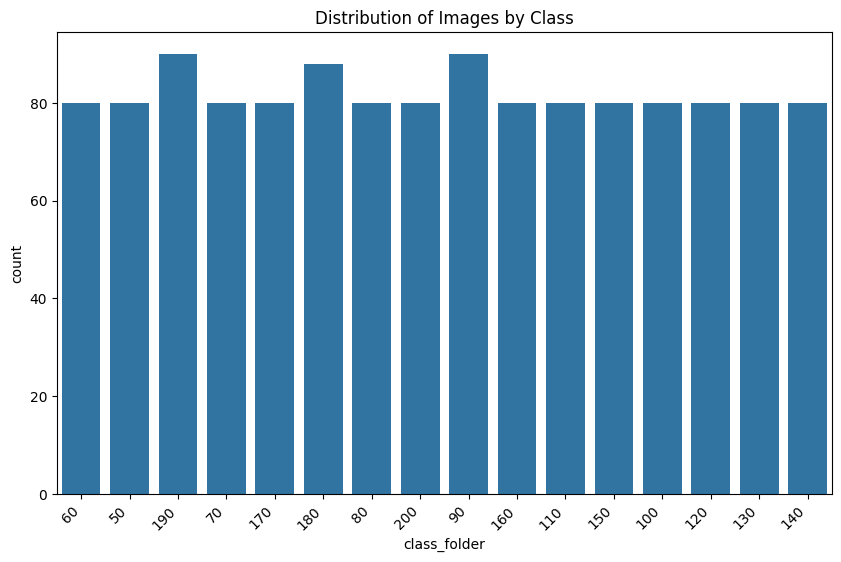

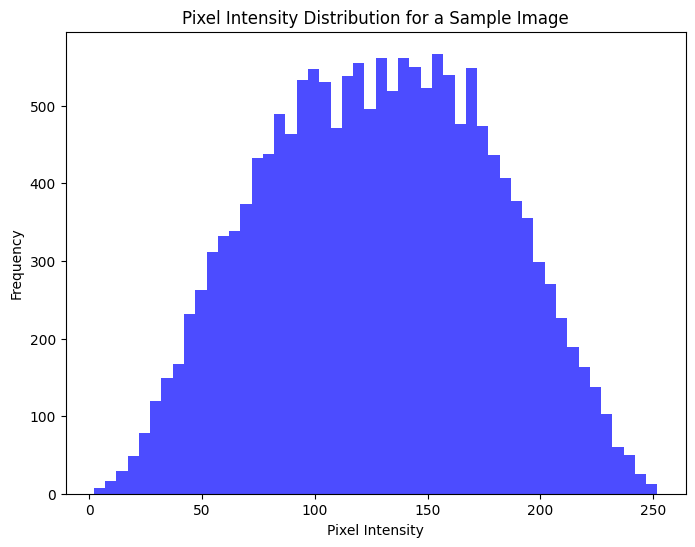

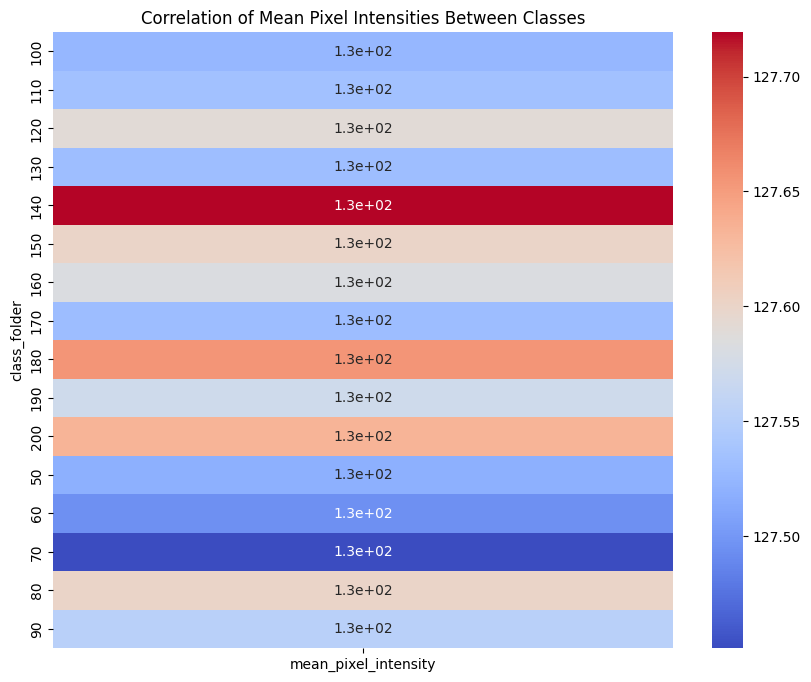

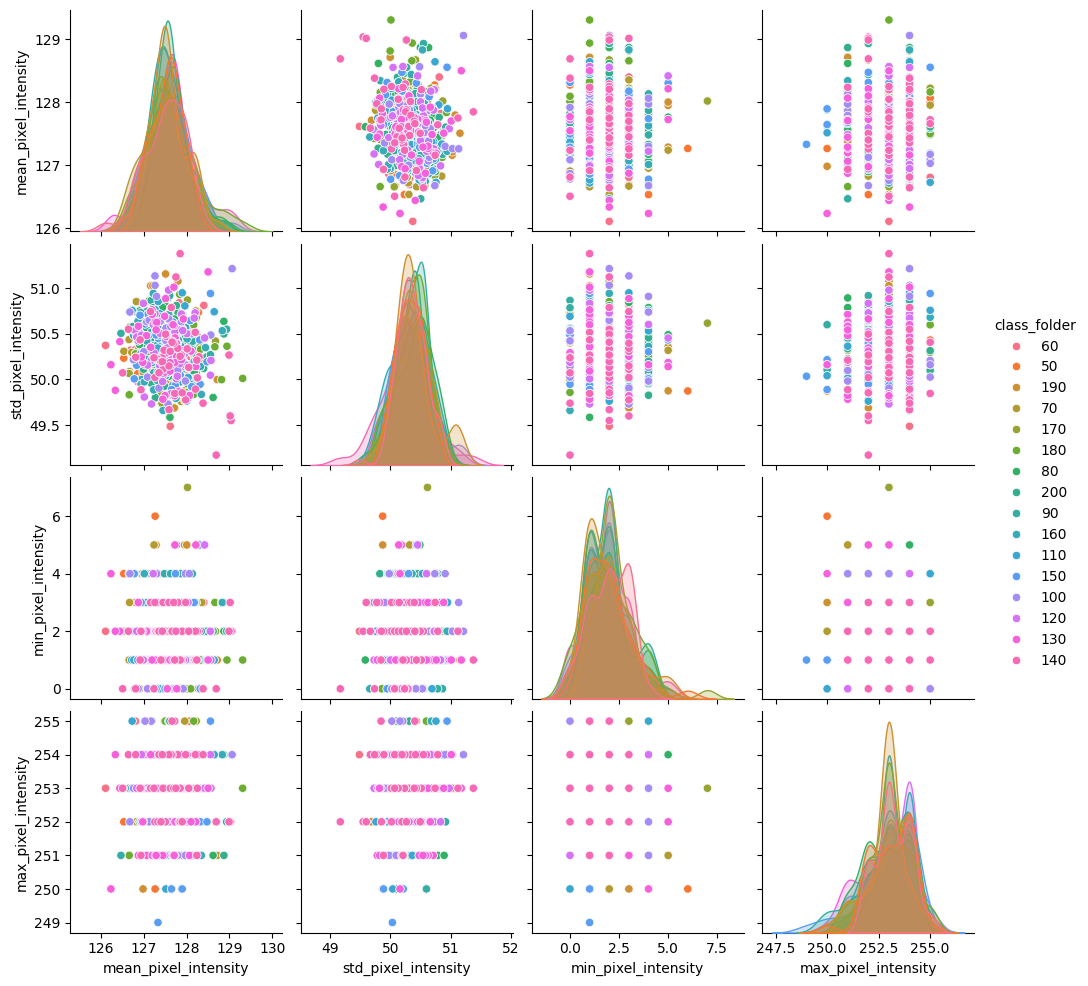

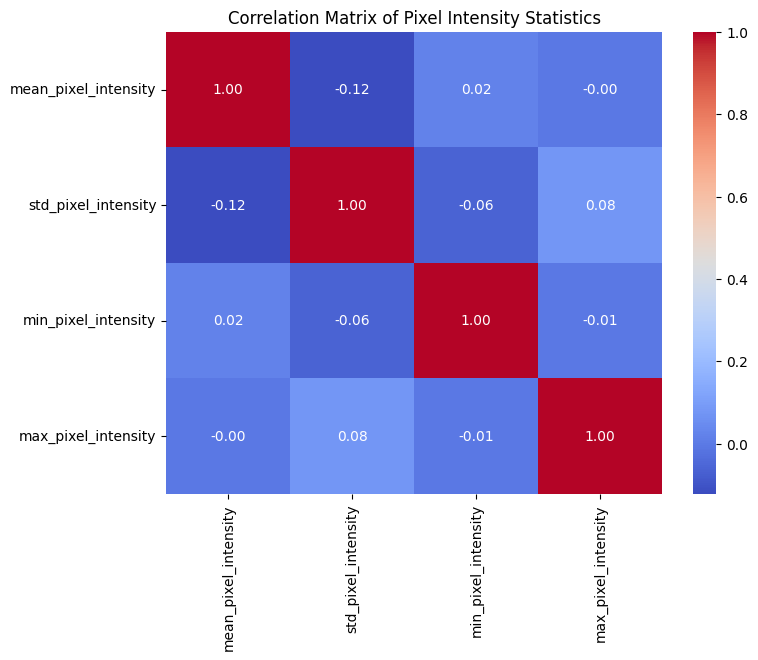

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths for image directory and where to save the CSV
image_dir = '/content/drive/MyDrive/Colab Notebooks/FEDM/prepro'
save_csv_path = '/content/drive/MyDrive/Colab Notebooks/FEDM/raw_data.csv'

# Step 1: Traverse through directories and load image data
image_data_list = []  # Initialize list to store image data
valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # List of valid image file extensions

# Loop through folders (classes) in the image directory
for class_folder in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_folder)  # Path to each class folder
    if os.path.isdir(class_path):  # Check if path is a directory
        # Loop through each file in the class folder
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)  # Full path to the image file
            ext = os.path.splitext(image_file)[1].lower()  # Get file extension and convert to lowercase

            # Check if the file has a valid image extension
            if ext in valid_image_extensions:
                try:
                    image = Image.open(image_path).convert('L')  # Open and convert image to grayscale
                    image_data = np.array(image).flatten()  # Flatten image data to a 1D array
                    image_data_list.append([class_folder, image_file, image_data.tolist()])  # Append class, file, and data
                except UnidentifiedImageError:  # Catch errors for unreadable images
                    print(f"Cannot identify image file: {image_path}")
                    continue  # Skip unreadable images

# Step 2: Create a DataFrame with collected image data
df = pd.DataFrame(image_data_list, columns=['class_folder', 'image_file', 'image_data'])

# Step 3: Save the DataFrame as a CSV file
df.to_csv(save_csv_path, index=False)  # Save CSV without index column
print(f"Data saved to {save_csv_path}")

# Step 4: Visualization

# --- 1. Visualizing the class distribution ---
plt.figure(figsize=(10, 6))  # Set figure size
sns.countplot(data=df, x='class_folder')  # Create count plot for image distribution by class
plt.title('Distribution of Images by Class')  # Title for the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-ticks for better readability
plt.show()  # Display the plot

# --- 2. Pixel Intensity Distribution for a Sample Image ---
# Convert 'image_data' to numpy arrays (in case stored as lists in CSV)
df['image_data'] = df['image_data'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array(eval(x)))

# Select the pixel data for the first image in the DataFrame
sample_image_data = df['image_data'].iloc[0]

plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(sample_image_data, bins=50, color='blue', alpha=0.7)  # Plot histogram for pixel intensity
plt.title('Pixel Intensity Distribution for a Sample Image')  # Title for the histogram
plt.xlabel('Pixel Intensity')  # Label for x-axis
plt.ylabel('Frequency')  # Label for y-axis
plt.show()  # Display the histogram

# --- 3. Calculating and Visualizing the Correlation of Mean Pixel Intensity Between Classes ---
df['mean_pixel_intensity'] = df['image_data'].apply(np.mean)  # Calculate mean pixel intensity for each image

plt.figure(figsize=(10, 8))  # Set figure size
# Create heatmap for mean pixel intensity correlation between classes
sns.heatmap(df.pivot_table(index='class_folder', values='mean_pixel_intensity', aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title('Correlation of Mean Pixel Intensities Between Classes')  # Title for heatmap
plt.show()  # Display the heatmap

# --- 4. Pairplot of Image Statistics ---
df['std_pixel_intensity'] = df['image_data'].apply(np.std)  # Calculate standard deviation of pixel intensity for each image
df['min_pixel_intensity'] = df['image_data'].apply(np.min)  # Calculate minimum pixel intensity for each image
df['max_pixel_intensity'] = df['image_data'].apply(np.max)  # Calculate maximum pixel intensity for each image

# Create pairplot of mean, std, min, max pixel intensity, color-coded by class
sns.pairplot(df[['mean_pixel_intensity', 'std_pixel_intensity', 'min_pixel_intensity', 'max_pixel_intensity', 'class_folder']], hue='class_folder')
plt.show()  # Display the pairplot

# --- 5. Heatmap of Correlation Matrix ---

# Create a DataFrame of pixel intensity statistics
stats_df = df[['mean_pixel_intensity', 'std_pixel_intensity', 'min_pixel_intensity', 'max_pixel_intensity']]

# Calculate the correlation matrix for these statistics
correlation_matrix = stats_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pixel Intensity Statistics')
plt.show()


# Step 6: Prepare the pixel data matrix
# Convert 'image_data' column to a matrix format for correlation analysis
pixel_data_matrix = np.array(df['image_data'].tolist())  # Each row is an image, each column is a pixel

# Step 7: Compute the correlation matrix of pixel values
corr_matrix = np.corrcoef(pixel_data_matrix, rowvar=False)  # Calculate correlations between pixels

# Set up labels for pixels on both axes
pixel_labels = [f"Pixel {i+1}" for i in range(pixel_data_matrix.shape[1])]

# Optional: Mask the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Display the correlation matrix with labeled axes
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,  # Apply the mask
    cmap='coolwarm',
    annot=False,
    cbar=True,
    xticklabels=pixel_labels if len(pixel_labels) <= 50 else 50,
    yticklabels=pixel_labels if len(pixel_labels) <= 50 else 50
)
plt.title('Correlation Between Pixel Intensities')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.tight_layout()
plt.show()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing

In [ ]:
import os
import csv
import random
from PIL import Image
from torchvision import transforms

# Paths to the root training directory and the output CSV file path
train_dir = r'/content/drive/MyDrive/Colab Notebooks/FEDM/Training Set'  # Directory containing the training images
output_csv = r'/content/drive/MyDrive/Colab Notebooks/FEDM/TRAING_images.csv'  # Path where preprocessed image data will be saved as a CSV file

# Define image preprocessing transformations using torchvision.transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors (and scale pixel values to [0,1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image using ImageNet mean and std
])

# Function to balance the number of images in each class folder
def balance_images(class_folder_path, target_count=80):
    image_files = [img for img in os.listdir(class_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    if len(image_files) > target_count:
        # Randomly select images to delete
        images_to_delete = random.sample(image_files, len(image_files) - target_count)
        for img_file in images_to_delete:
            os.remove(os.path.join(class_folder_path, img_file))
    elif len(image_files) < target_count:
        # Randomly duplicate images until we reach the target count
        images_to_duplicate = random.choices(image_files, k=target_count - len(image_files))
        for img_file in images_to_duplicate:
            original_img_path = os.path.join(class_folder_path, img_file)
            duplicated_img_path = os.path.join(class_folder_path, f"dup_{img_file}")
            Image.open(original_img_path).save(duplicated_img_path)

# Function to preprocess images and save the preprocessed data into a CSV file
def preprocess_and_save_to_csv(train_dir, output_csv, transform):
    # Open the CSV file in write mode
    with open(output_csv, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)  # Create a CSV writer object
        # Write the header of the CSV file (column names)
        writer.writerow(['file_name', 'class_folder', 'image_data'])

        # Iterate through each folder (representing a class) in the training directory
        for class_folder in os.listdir(train_dir):
            class_folder_path = os.path.join(train_dir, class_folder)  # Build the full path to the class folder

            if os.path.isdir(class_folder_path):  # Ensure we are processing directories only (i.e., classes)
                balance_images(class_folder_path)  # Balance the number of images in each class folder

                # Process each image file after balancing
                for img_file in os.listdir(class_folder_path):
                    img_path = os.path.join(class_folder_path, img_file)  # Build the full path to the image file

                    # Process only image files (check the extension)
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        try:
                            # Open the image file using PIL
                            with Image.open(img_path) as img:
                                # Apply the defined transformations (resize, tensor conversion, normalization)
                                preprocessed_img = transform(img)

                                # Flatten the preprocessed image tensor into a 1D list for saving in the CSV
                                flattened_image = preprocessed_img.flatten().tolist()

                                # Write the image's filename, class folder, and preprocessed image data to the CSV
                                writer.writerow([img_file, class_folder, flattened_image])

                        except Exception as e:
                            # Print error if the image processing fails for any reason
                            print(f"Error processing image {img_path}: {e}")
                    else:
                        # Print a message if the file is not an image (i.e., skipped non-image files)
                        print(f"Skipped non-image file: {img_path}")

# Run the function to preprocess the images and save the data to the CSV file
preprocess_and_save_to_csv(train_dir, output_csv, transform)

# Print a message when preprocessing is complete
print(f"Preprocessing complete. Data saved in {output_csv}")


Preprocessing complete. Data saved in /content/drive/MyDrive/Colab Notebooks/FEDM/TRAING_images.csv


## Pre-Processed Data visualization

          file_name  class_folder  \
0         4 (4).jpg           190   
1         3 (2).jpg           190   
2      3 - Copy.jpg           190   
3  1 (1) - Copy.jpg           190   
4  3 (4) - Copy.jpg           190   

                                          image_data  
0  [-0.028684020042419434, -2.1179039478302, -1.0...  
1  [-1.0219197273254395, -0.7479236125946045, -1....  
2  [0.4165596663951874, 1.3584210872650146, 0.348...  
3  [-0.919171154499054, -0.4568028450012207, -0.0...  
4  [1.3070467710494995, 0.21106265485286713, -1.3...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     1280 non-null   object
 1   class_folder  1280 non-null   int64 
 2   image_data    1280 non-null   object
dtypes: int64(1), object(2)
memory usage: 30.1+ KB
None


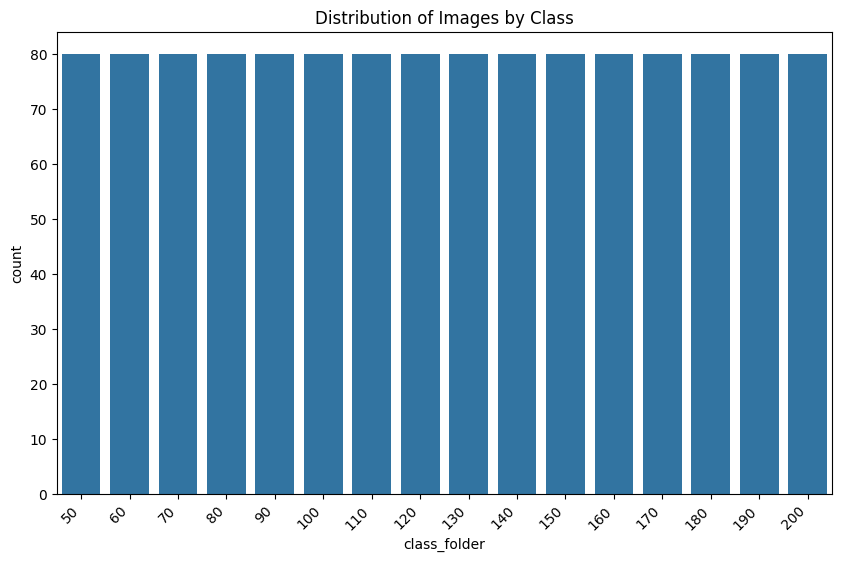

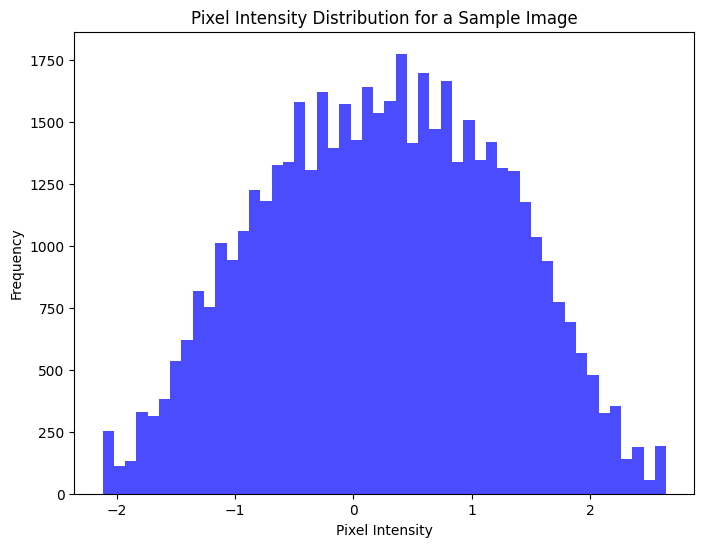

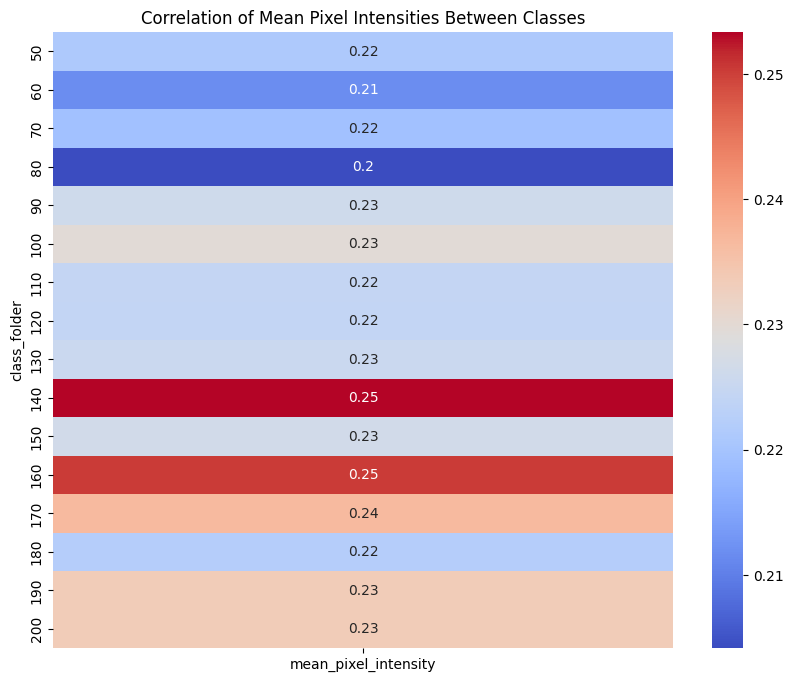

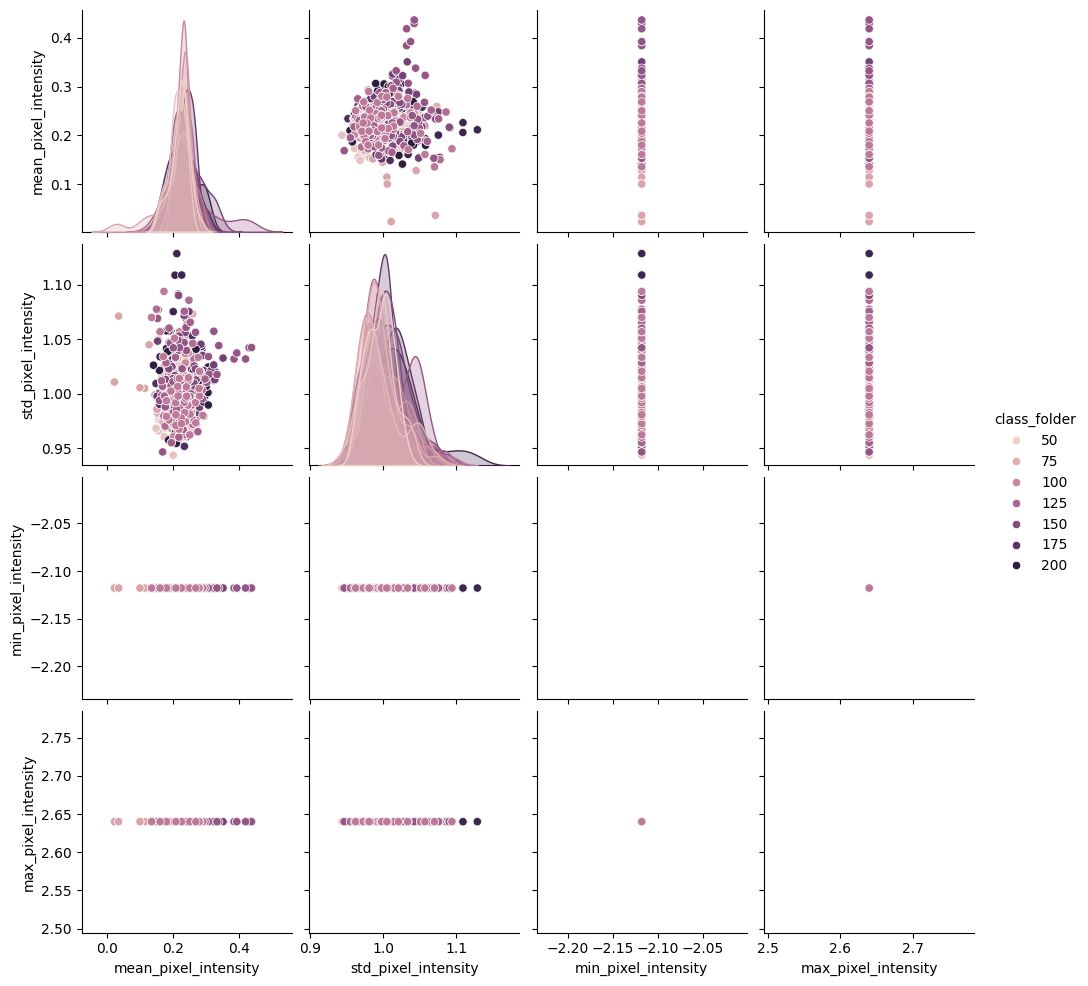

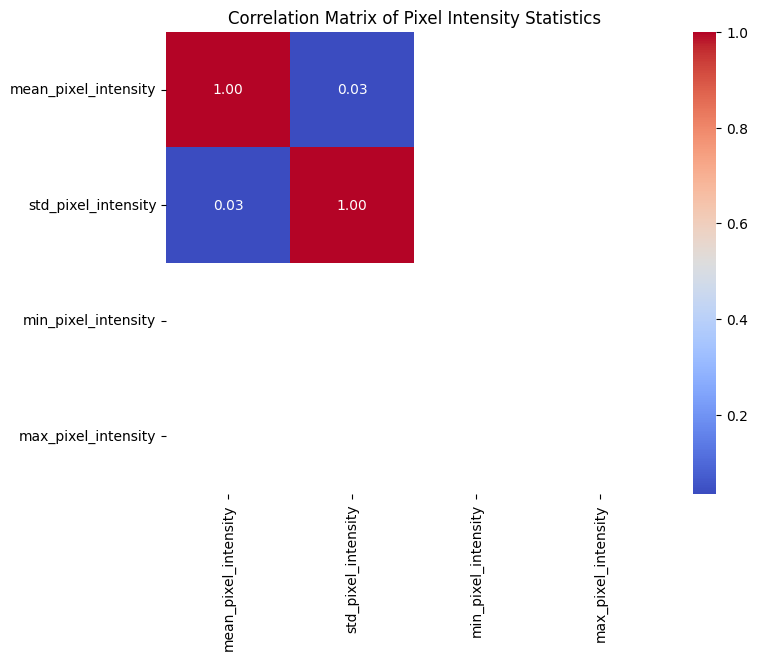

In [ ]:
# Import necessary libraries
import pandas as pd           # For loading and handling CSV files
import numpy as np            # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns         # For enhanced data visualization

# Load the preprocessed images CSV file into a pandas DataFrame
csv_path = r'/content/drive/MyDrive/Colab Notebooks/FEDM/preprocessed_images.csv'
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame to check its structure
print(df.head())

# Print the information about the DataFrame (column names, data types, non-null counts)
print(df.info())

# --- 1. Visualizing the class distribution ---

# Plot the distribution of images by class (the 'class_folder' column contains the classes)
plt.figure(figsize=(10, 6))  # Set figure size
sns.countplot(data=df, x='class_folder')  # Create a count plot for image classes
plt.title('Distribution of Images by Class')  # Add a title to the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plot

# --- 2. Pixel Intensity Distribution for a Sample Image ---

# Convert the 'image_data' column from string to numpy arrays
# 'eval' is used to convert string representations of lists into actual lists
df['image_data'] = df['image_data'].apply(lambda x: np.array(eval(x)))

# Select the first image's pixel data (assuming the first row for demonstration)
sample_image_data = df['image_data'].iloc[0]

# Plot the histogram of pixel intensity distribution for the selected image
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(sample_image_data, bins=50, color='blue', alpha=0.7)  # Plot the pixel intensity
plt.title('Pixel Intensity Distribution for a Sample Image')  # Add plot title
plt.xlabel('Pixel Intensity')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis
plt.show()  # Display the plot

# --- 3. Calculating and Visualizing the Correlation of Mean Pixel Intensity Between Classes ---

# Calculate the mean pixel intensity for each image and create a new column 'mean_pixel_intensity'
df['mean_pixel_intensity'] = df['image_data'].apply(np.mean)

# Create a pivot table to get the average mean pixel intensity for each class
# Then, plot a heatmap to visualize the correlation of pixel intensities between classes
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(df.pivot_table(index='class_folder', values='mean_pixel_intensity', aggfunc='mean'), annot=True, cmap='coolwarm')
plt.title('Correlation of Mean Pixel Intensities Between Classes')  # Add a title to the plot
plt.show()  # Display the heatmap

# --- 4. Pairplot of Image Statistics ---

# Calculate additional image statistics like standard deviation, minimum, and maximum pixel intensity
df['std_pixel_intensity'] = df['image_data'].apply(np.std)  # Standard deviation
df['min_pixel_intensity'] = df['image_data'].apply(np.min)  # Minimum pixel intensity
df['max_pixel_intensity'] = df['image_data'].apply(np.max)  # Maximum pixel intensity

# Use seaborn's pairplot to visualize the relationships between these statistics for each class
sns.pairplot(df[['mean_pixel_intensity', 'std_pixel_intensity', 'min_pixel_intensity', 'max_pixel_intensity', 'class_folder']], hue='class_folder')
plt.show()  # Show the pairplot

# --- 5. Heatmap of Correlation Matrix ---

# Create a DataFrame of pixel intensity statistics
stats_df = df[['mean_pixel_intensity', 'std_pixel_intensity', 'min_pixel_intensity', 'max_pixel_intensity']]

# Calculate the correlation matrix for these statistics
correlation_matrix = stats_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pixel Intensity Statistics')
plt.show()


## Feature Extraction

In [ ]:
import cv2  # Import OpenCV for image processing
import numpy as np  # Import NumPy for numerical operations
import os  # Import OS module for directory operations
import pandas as pd  # Import Pandas for DataFrame operations
from tqdm import tqdm  # Import tqdm for displaying progress bars
from scipy.stats import skew, kurtosis, entropy  # Import statistical functions from scipy
from glob import glob  # Import glob for pattern matching in directory paths

# Define the base directory path containing the 16 class folders with images
base_dir = '/content/drive/MyDrive/Colab Notebooks/FEDM/PrePro/valid prepro'

# Initialize an empty list to store features and class labels for each image
features_data = []

# Function to calculate smoothness of an image
def smoothness(image):
    # Smoothness formula based on image variance
    return 1 - (1 / (1 + np.var(image)))

# Function to extract specified features from each image
def extract_features(image):
    # Convert the image to grayscale to simplify feature extraction
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the mean and standard deviation of each pixel intensities
    mean, stddev = cv2.meanStdDev(gray_image)
    mean = mean[0][0]  # Extract mean value from the result array
    stddev = stddev[0][0]  # Extract standard deviation value

    # Compute variance of each pixel intensities
    variance = np.var(gray_image)

    # Flatten the image to a 1D array to compute skewness and kurtosis
    flat_gray = gray_image.flatten()
    skewness_val = skew(flat_gray)  # Compute skewness
    kurtosis_val = kurtosis(flat_gray)  # Compute kurtosis

    # Compute energy as the sum of squared each pixel intensities
    energy = np.sum(gray_image ** 2)

    # Compute entropy based on each pixel intensity histogram
    hist, _ = np.histogram(flat_gray, bins=256, density=True)  # Histogram for entropy calculation
    entropy_val = entropy(hist)  # Calculate entropy

    # Compute smoothness based on the image's variance
    smoothness_val = smoothness(gray_image)

    # Return all extracted features as a list
    return [mean, stddev, variance, skewness_val, kurtosis_val, energy, entropy_val, smoothness_val]

# Define supported image extensions for loading different image formats
image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff"]
all_image_paths = []  # List to store all image paths

# Loop through each extension and gather all matching image paths in subdirectories
for ext in image_extensions:
    # Use glob to search for images with the specified extension
    all_image_paths.extend(glob(os.path.join(base_dir, "*", ext)))

# Process each image path with a progress bar to show progress across all images
for image_path in tqdm(all_image_paths, desc="Processing images"):
    # Extract class label from the folder name (assumes each folder is a class)
    class_label = os.path.basename(os.path.dirname(image_path))

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was successfully loaded
    if image is not None:
        # Extract features from the loaded image
        features = extract_features(image)

        # Append the class label and features to the list
        features_data.append([class_label] + features)

# Define column names for the DataFrame
columns = ['Class_Label', 'Mean', 'StdDev', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy', 'Smoothness']
# Create a DataFrame with extracted features
features_df = pd.DataFrame(features_data, columns=columns)

# Define path to save the output CSV file
csv_output_path = '/content/drive/MyDrive/Colab Notebooks/FEDM/PrePro/V_features.csv'
# Save the DataFrame to a CSV file without including the index
features_df.to_csv(csv_output_path, index=False)

# Print completion message with the CSV file path
print(f"Feature extraction completed. Saved to {csv_output_path}")


Processing images: 100%|██████████| 160/160 [01:24<00:00,  1.89it/s]

Feature extraction completed. Saved to /content/drive/MyDrive/Colab Notebooks/FEDM/PrePro/V_features.csv


## Concatenation

In [ ]:
import pandas as pd

# Load the CSV files
file1 = '/content/drive/MyDrive/Colab Notebooks/FEDM/PrePro/V_features.csv'
file2 = '/content/drive/MyDrive/Colab Notebooks/FEDM/PrePro/image_features.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Concatenate the DataFrames (row-wise)
df_concat = pd.concat([df1, df2], axis=0)

# Specify the output path with a filename
output_path = '/content/drive/MyDrive/Colab Notebooks/FEDM/concatenated_data.csv'

# Save the concatenated DataFrame to the specified path
df_concat.to_csv(output_path, index=False)

print(f"Files concatenated and saved to {output_path} successfully!")


Files concatenated and saved to /content/drive/MyDrive/Colab Notebooks/FEDM/concatenated_data.csv successfully!


## Feature Extration Visualization

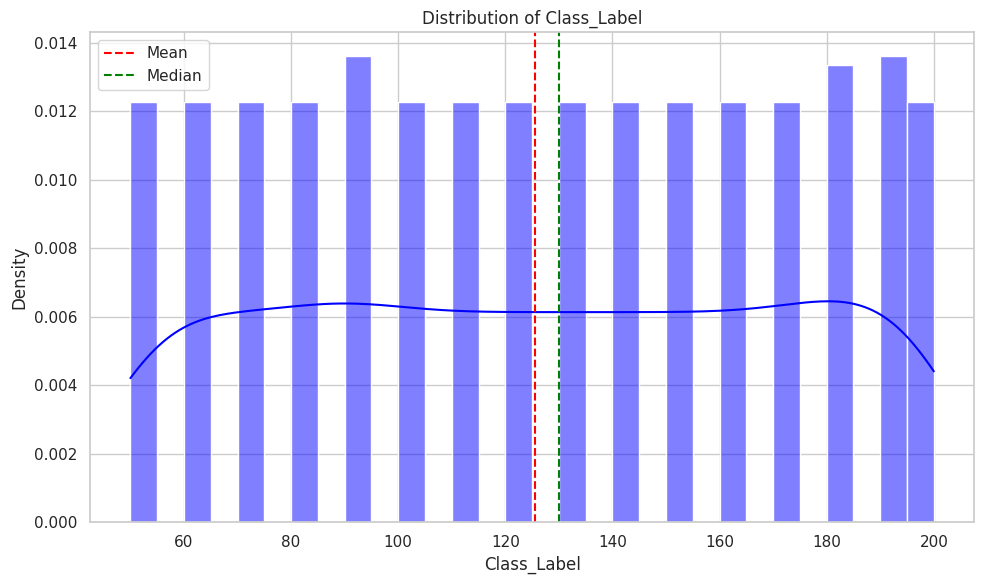

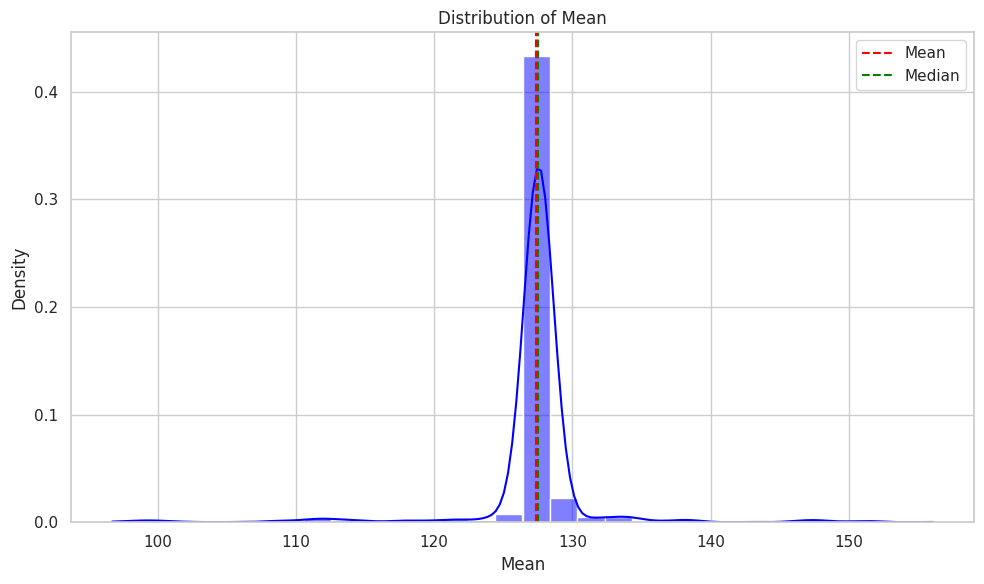

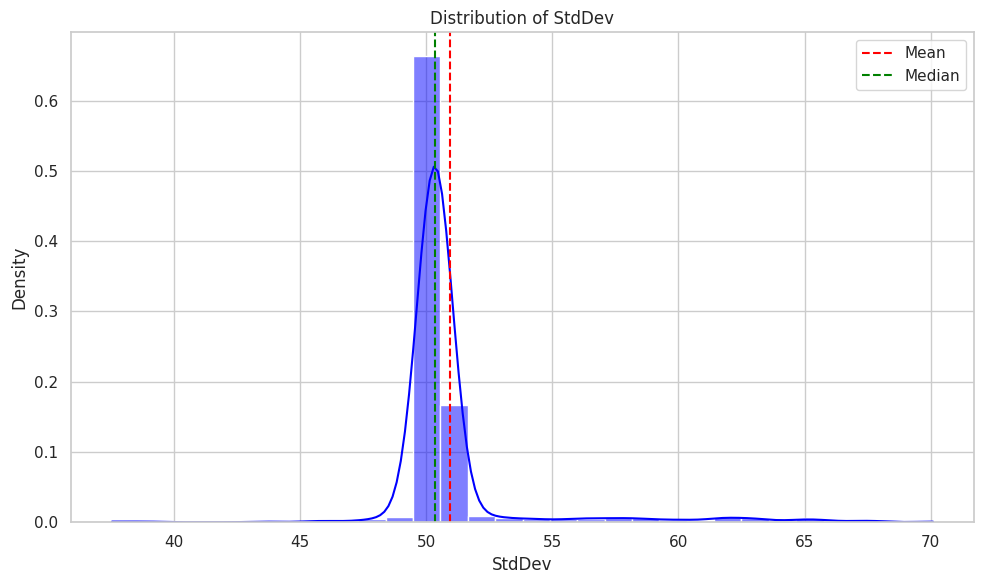

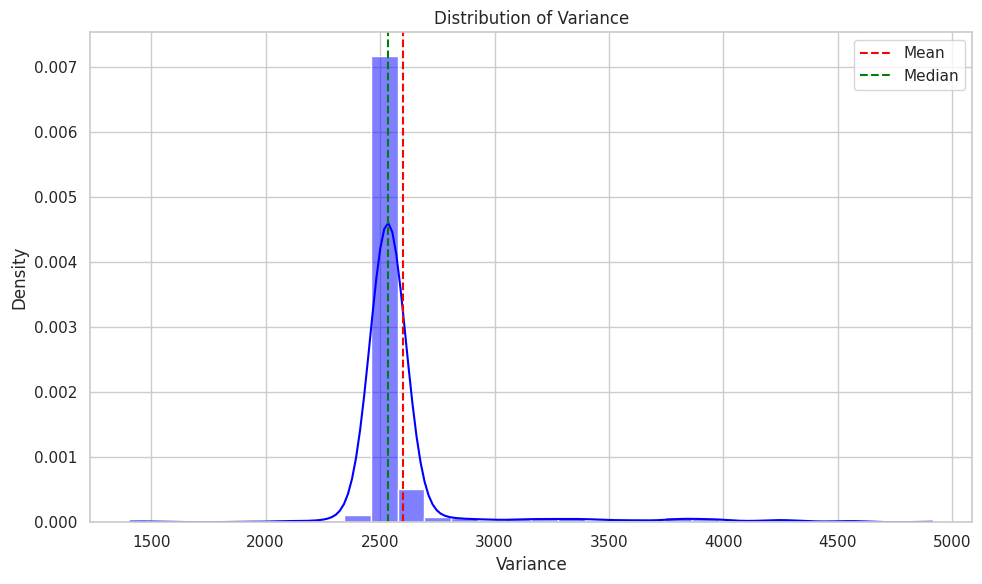

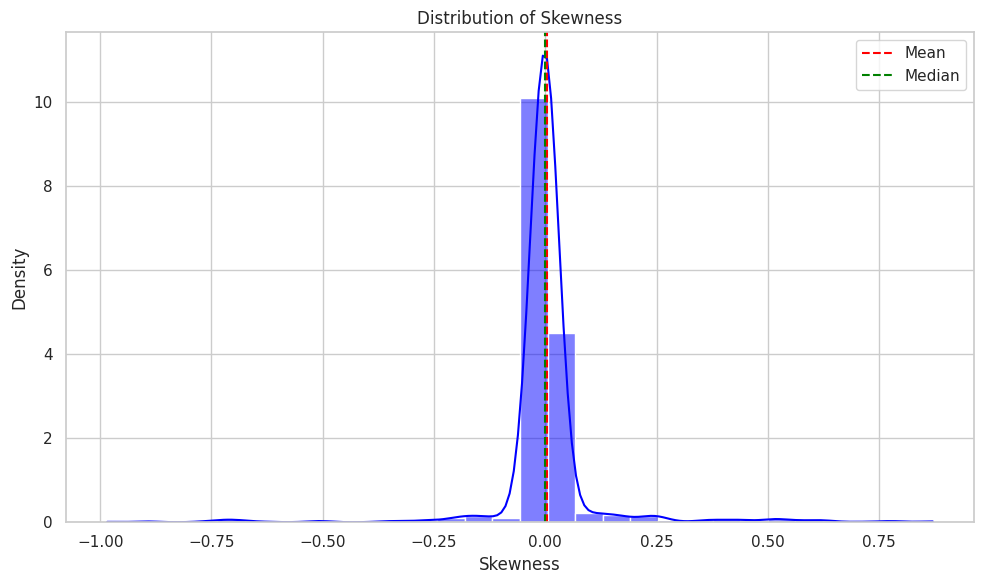

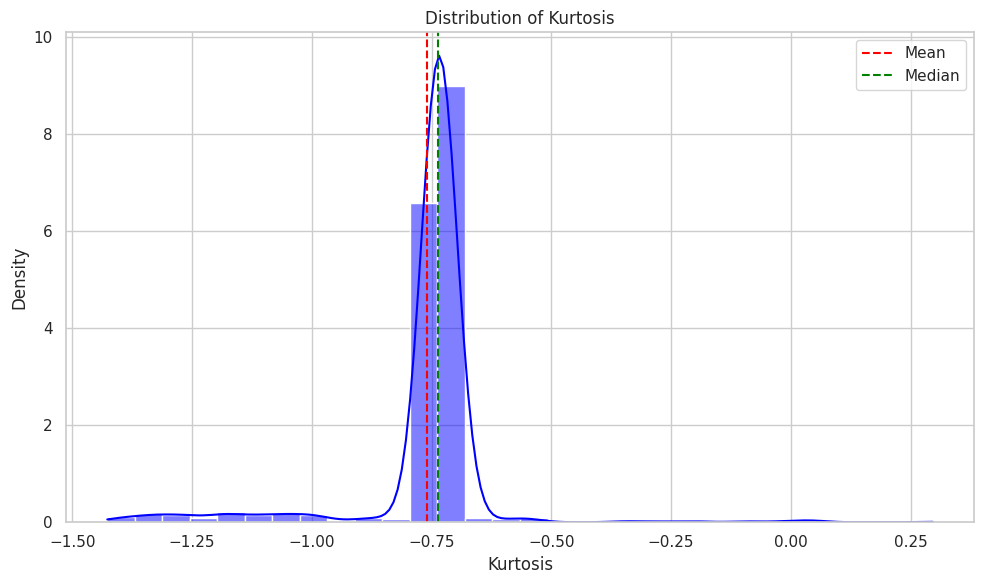

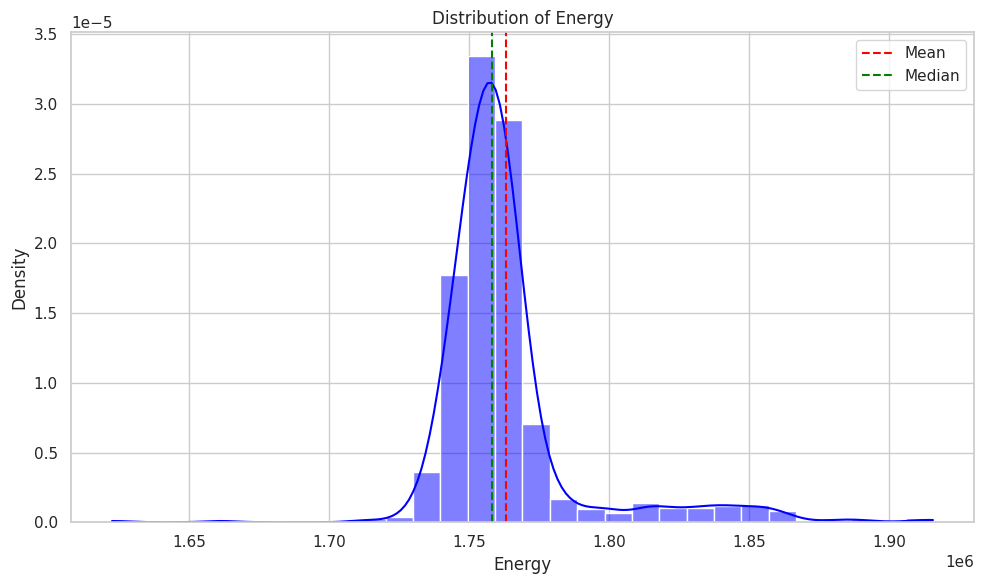

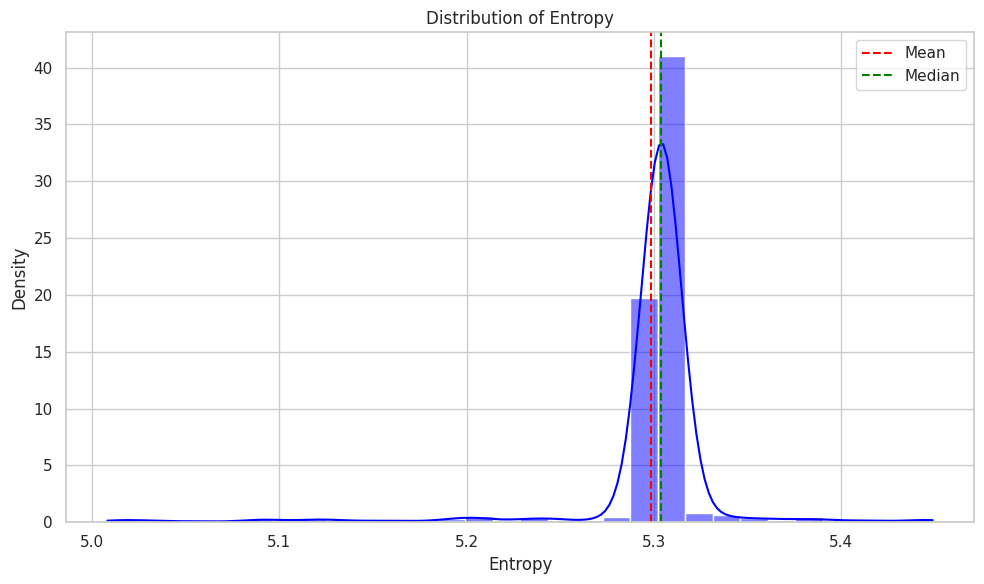

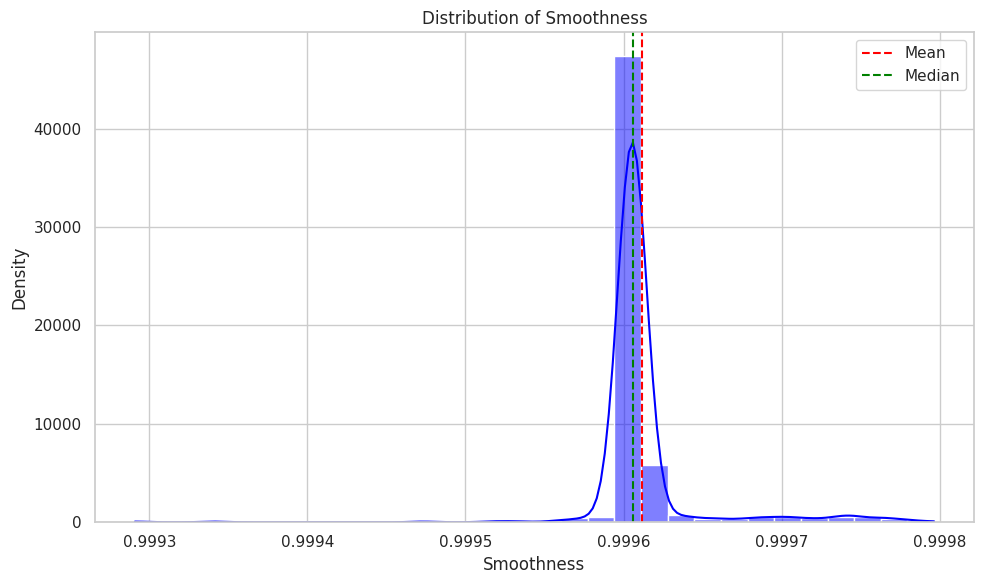

In [ ]:
import seaborn as sns  # Seaborn for enhanced data visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting
import pandas as pd  # Pandas for data manipulation

# Function to visualize features from the extracted CSV file
def visualize_features_from_csv(csv_file):
    """Function to visualize features using histograms with KDE."""

    # Load the extracted features from the CSV file
    features_df = pd.read_csv(csv_file)  # Read the CSV into a DataFrame

    # Set the style for seaborn
    sns.set(style="whitegrid")  # Set a style for the plots

    # Loop through each feature (excluding filename and label)
    for feature in features_df.columns:
        if feature not in ['filename', 'label']:  # Exclude non-feature columns
            plt.figure(figsize=(10, 6))  # Set figure size for each plot
            sns.histplot(features_df[feature], kde=True, bins=30, color='blue', stat='density')  # Create histogram with KDE
            plt.title(f'Distribution of {feature}')  # Title of the plot
            plt.xlabel(feature)  # X-axis label
            plt.ylabel('Density')  # Y-axis label
            plt.axvline(features_df[feature].mean(), color='red', linestyle='--', label='Mean')  # Mean line
            plt.axvline(features_df[feature].median(), color='green', linestyle='--', label='Median')  # Median line
            plt.legend()  # Show legend
            plt.tight_layout()  # Adjust layout
            plt.show()  # Show the plot

# Example usage of the function
if __name__ == "__main__":
    # Specify the path to the CSV file containing the extracted features
    csv_file = os.path.join(output_dir, '/content/drive/MyDrive/Colab Notebooks/FEDM/concatenated_data.csv')  # Update with your actual file name
    visualize_features_from_csv(csv_file)  # Call the visualization function


## Feature Selection using Wrapper Method

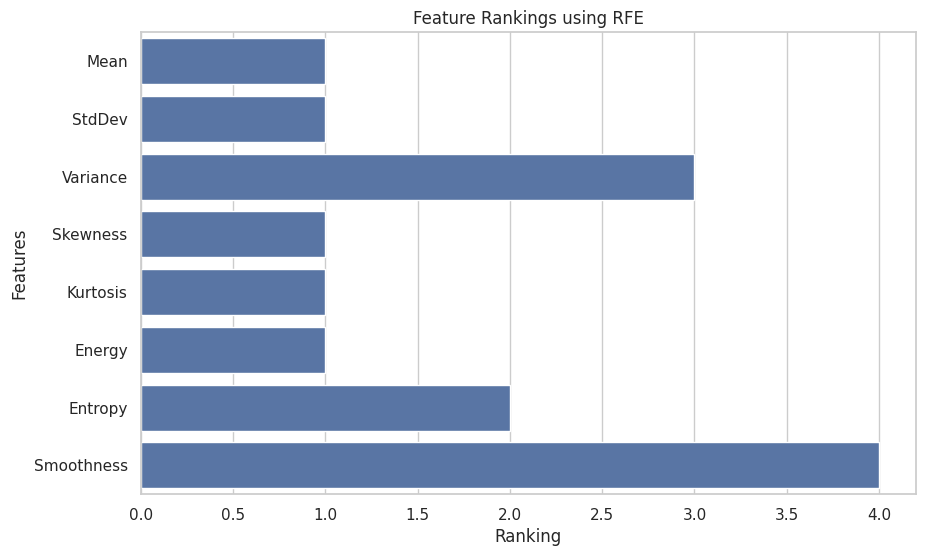

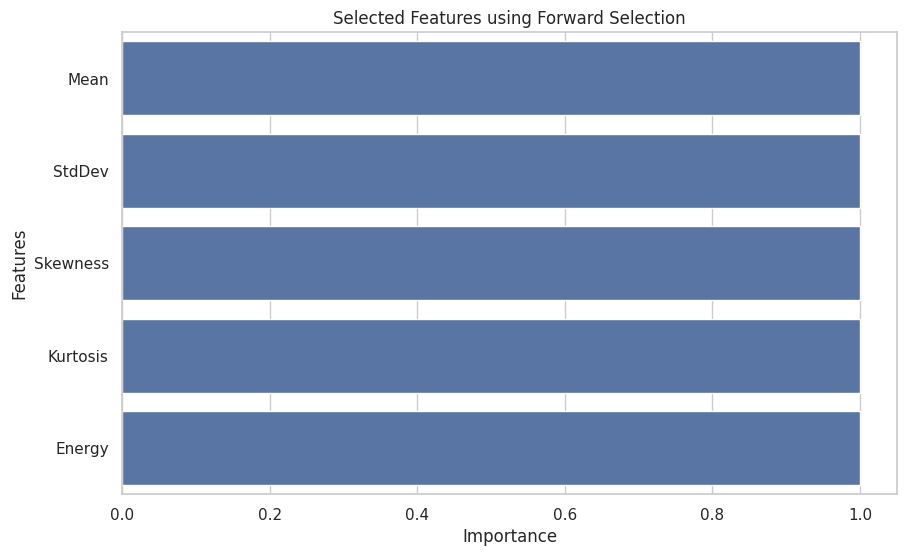

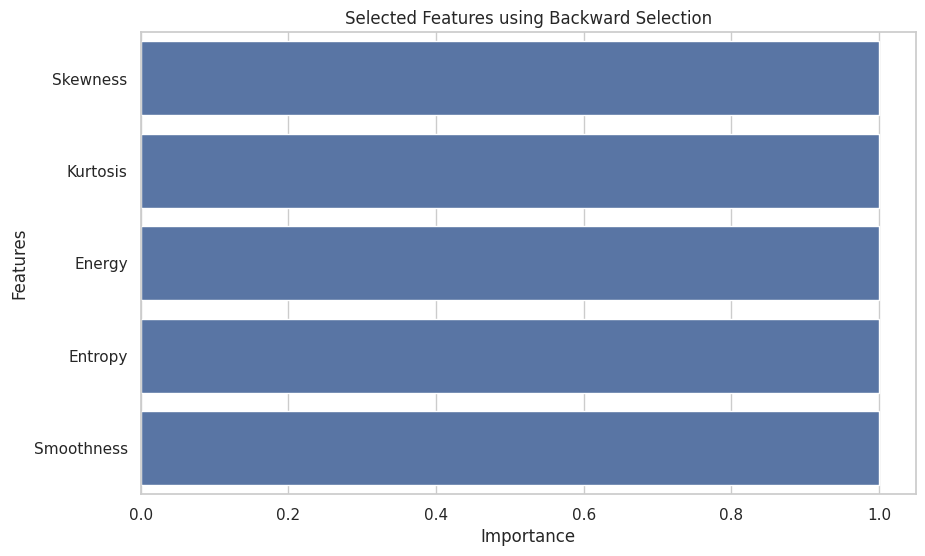

Accuracy using RFE selected features:  0.6575963718820862


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# Load the CSV file
file_path = '/content/drive/MyDrive/Colab Notebooks/FEDM/concatenated_data.csv'
df = pd.read_csv(file_path)

# Separate features (X) and the label (y)
# Assuming 'label' is the target column
X = df.drop(columns=['Class_Label'])  # Drop the label column from the features
y = df['Class_Label']  # Store the label in y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a RandomForest model as the estimator for feature selection
model = RandomForestClassifier(random_state=42)

# Get the number of features in X_train
n_features = X_train.shape[1]  # Number of features in the dataset

# Ensure 'n_features_to_select' is less than the total number of features
n_features_to_select = min(5, n_features)  # Select 5 features (or fewer)

# --------------------- Recursive Feature Elimination (RFE) ---------------------

# Perform RFE to select the 5 best features
rfe = RFE(model, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)  # Fit RFE on the training data

# Get the feature rankings from RFE
ranking = rfe.ranking_
features = X.columns  # Feature names

# Plot the feature ranking
plt.figure(figsize=(10, 6))
sns.barplot(x=ranking, y=features)
plt.title('Feature Rankings using RFE')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.show()

# -------------------- Wrapper Forward Selection ---------------------

# Perform Forward Selection to select the best features
forward_selector = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, direction='forward')
forward_selector.fit(X_train, y_train)  # Fit forward selector on the training data

# Extract the selected features from the forward selection
selected_features_fwd = np.array(features)[forward_selector.get_support()]

# Plot the selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=np.ones(len(selected_features_fwd)), y=selected_features_fwd)
plt.title('Selected Features using Forward Selection')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# -------------------- Wrapper Backward Selection ---------------------

# Perform Backward Selection to select the best features
backward_selector = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select, direction='backward')
backward_selector.fit(X_train, y_train)  # Fit backward selector on the training data

# Extract the selected features from the backward selection
selected_features_bwd = np.array(features)[backward_selector.get_support()]

# Plot the selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=np.ones(len(selected_features_bwd)), y=selected_features_bwd)
plt.title('Selected Features using Backward Selection')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# --------------------- Model Evaluation ---------------------

# Use the features selected by RFE for training the model
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Train the model on the selected features
model.fit(X_train_rfe, y_train)

# Predict using the model trained on RFE-selected features
y_pred = model.predict(X_test_rfe)

# Print the accuracy score to evaluate the performance
print("Accuracy using RFE selected features: ", accuracy_score(y_test, y_pred))
